# ConvNeXt_tiny model - fabric 데이터 학습시키기

##  1. 데이터 전처리

In [1]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision

In [2]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
train_dataset = ImageFolder(root="./dataset/train", transform=transforms_train)
test_dataset = ImageFolder(root="./dataset/test", transform=transforms_test)

In [4]:
print(train_dataset.classes)

['Acrylic', 'Artificial_fur', 'Artificial_leather', 'Blended', 'Chenille', 'Corduroy', 'Cotton', 'Crepe', 'Denim', 'Felt', 'Fleece', 'Leather', 'Linen', 'Lut', 'Nylon', 'Polyester', 'Satin', 'Silk', 'Suede', 'Terrycloth', 'Utilities', 'Velvet', 'Viscose', 'Wool']


In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
images, labels = next(iter(train_dataloader))

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 화면에 출력하는 함수
def imshow(img, title) :
    img = img.numpy().transpose([1, 2, 0])

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    img = img * std + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.title(title)
    plt.show()

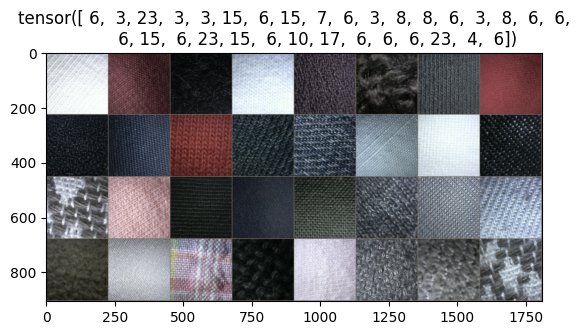

In [8]:
images_data = torchvision.utils.make_grid(images)
imshow(images_data, labels)

In [9]:
images.shape

torch.Size([32, 3, 224, 224])

## 2. 모델 불러오기

In [10]:
from torchvision.models import convnext_tiny
import torch.nn as nn

model = convnext_tiny(pretrained=True)
model

c:\IoLaundry\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\IoLaundry\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [13]:
# Classifier 수정
model.classifier[2] = nn.Linear(model.classifier[2].in_features, 24, bias=True)

In [14]:
model.classifier

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=24, bias=True)
)

## 3. 모델 학습

In [15]:
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

In [16]:
from tensorboardX import SummaryWriter
import torch.optim as optim
import tqdm

writer = SummaryWriter()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
epochs = 20
step = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for epoch in range(epochs) :
    for data, labels in tqdm.tqdm(train_dataloader) :
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        
        writer.add_scalar("Loss/train", loss.item(), step)
        step += 1
    
    print(f"{epoch+1} loss ::: {loss.item()}")

100%|██████████| 185/185 [02:01<00:00,  1.53it/s]


1 loss ::: 1.1670175790786743


100%|██████████| 185/185 [02:48<00:00,  1.10it/s]


2 loss ::: 0.6786787509918213


100%|██████████| 185/185 [02:56<00:00,  1.05it/s]


3 loss ::: 0.6549093127250671


100%|██████████| 185/185 [02:55<00:00,  1.05it/s]


4 loss ::: 0.8406047224998474


100%|██████████| 185/185 [02:55<00:00,  1.05it/s]


5 loss ::: 0.5827764868736267


100%|██████████| 185/185 [03:01<00:00,  1.02it/s]


6 loss ::: 0.771133303642273


100%|██████████| 185/185 [02:57<00:00,  1.04it/s]


7 loss ::: 0.614194393157959


100%|██████████| 185/185 [02:57<00:00,  1.04it/s]


8 loss ::: 0.6006264686584473


100%|██████████| 185/185 [02:53<00:00,  1.06it/s]


9 loss ::: 0.7434454560279846


100%|██████████| 185/185 [02:59<00:00,  1.03it/s]


10 loss ::: 0.6822459101676941


100%|██████████| 185/185 [03:02<00:00,  1.02it/s]


11 loss ::: 0.22573526203632355


100%|██████████| 185/185 [03:01<00:00,  1.02it/s]


12 loss ::: 0.2694251239299774


100%|██████████| 185/185 [02:55<00:00,  1.05it/s]


13 loss ::: 0.6735155582427979


100%|██████████| 185/185 [03:00<00:00,  1.03it/s]


14 loss ::: 0.44540107250213623


100%|██████████| 185/185 [03:26<00:00,  1.11s/it]


15 loss ::: 0.4372265040874481


100%|██████████| 185/185 [02:35<00:00,  1.19it/s]


16 loss ::: 0.6952460408210754


100%|██████████| 185/185 [01:52<00:00,  1.65it/s]


17 loss ::: 0.6194632053375244


100%|██████████| 185/185 [02:00<00:00,  1.54it/s]


18 loss ::: 0.23115882277488708


100%|██████████| 185/185 [02:06<00:00,  1.46it/s]


19 loss ::: 0.5336158871650696


100%|██████████| 185/185 [01:57<00:00,  1.57it/s]

20 loss ::: 0.6542991399765015


In [19]:
torch.save(model.state_dict(), "model/convNeXt_weight_1.pth")

In [18]:
torch.save(model, "model/convNeXt_full_1.pth")

## 4. 모델평가

In [20]:
import torch
from sklearn.metrics import f1_score

# 평가
model.eval()

all_preds = []
all_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad() :
    total_corr = 0
    for images, labels in test_dataloader :
        images = images.to(device)
        labels = labels.to(device)

        # 3. 모델 추론
        outputs = model(images)                 # (batch_size, num_classes)
        preds = torch.argmax(outputs, dim=1)    # 가장 확률 높은 클래스로 예측

        # 4. 결과 수집 (CPU로 옮기기)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# f1 score 계산
f1_macro = f1_score(all_labels, all_preds, average="macro")         # 적은 클래스도 똑같이 반영
f1_weighted = f1_score(all_labels, all_preds, average="weighted")   # 샘플 수 비율 반영 (-> 클래스 불균형 심할때)
print(f"f1 score (macro) : {f1_macro:.4f}")
print(f"f1 score (weighted) : {f1_weighted:.4f}")

f1 score (macro) : 0.8059
f1 score (weighted) : 0.7486


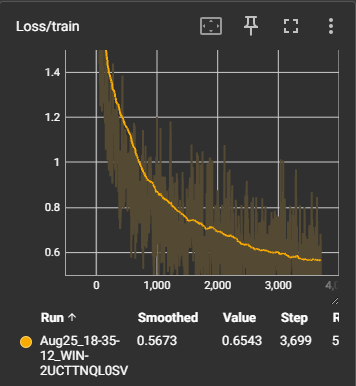

## 모델 재학습

### 1차 (주요클래스 추출)

- class = ['Acrylic', 'Artificial_fur', 'Artificial_leather', 'Blended', 'Chenille', 'Corduroy', 'Cotton', 'Crepe', 'Denim', 'Felt', 'Fleece', 'Leather', 'Linen', 'Lut', 'Nylon', 'Polyester', 'Satin', 'Silk', 'Suede', 'Terrycloth', 'Utilities', 'Velvet', 'Viscose', 'Wool']
- selected_indices = [7, 4, 16, 9, 24, 15, 18, 23, 11, 20, 8, 6]

#### 1) 데이터 불러오기

In [1]:
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

In [2]:
# 전처리
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
# 전체 데이터셋 중 특정클래스만 필터링
class FilteredImageFolder(Dataset):
    def __init__(self, imagefolder_dataset, selected_classes):
        # 1) 원본 샘플 중 selected_classes에 해당하는 것만 필터링
        filtered_samples = [
            (path, label)
            for path, label in imagefolder_dataset.samples
            if label in selected_classes
        ]

        # 2) 필터링된 라벨 리스트만 뽑아서 unique하게 정렬
        filtered_labels = sorted(set(label for _, label in filtered_samples))
        
        # 3) label -> 0-based index 매핑 딕셔너리 생성
        self.label_map = {label: idx for idx, label in enumerate(filtered_labels)}

        # 4) 필터링된 샘플을 (path, new_label) 형태로 재매핑
        self.samples = [
            (path, self.label_map[label])
            for path, label in filtered_samples
        ]

        self.transform = imagefolder_dataset.transform
        self.loader = imagefolder_dataset.loader

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = self.loader(path)
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# 데이터 경로 설정
train_dir = "./dataset/train"
test_dir = "./dataset/test"

# ImageFolder 불러오기 (transform은 나중에 FilteredImageFolder에서 씀)
train_raw = ImageFolder(train_dir)
test_raw = ImageFolder(test_dir)

selected_class_names = [
    'Cotton', 'Crepe', 'Polyester', 'Denim', 'Wool',
    'Blended', 'Nylon', 'Silk', 'Fleece', 'Viscose',
    'Corduroy', 'Terrycloth'
]

# ImageFolder에서 클래스 이름 → 인덱스 매핑
class_to_idx = train_raw.class_to_idx

# selected_class_names를 실제 ImageFolder 인덱스로 변환 ([6, 3, 15, 8, 23, 14, 17, 22, 10, 19, 7, 5])
selected_classes = [class_to_idx[name] for name in selected_class_names]
print("Selected classes indices:", selected_classes)

# 필터링된 Dataset 생성 (transform 포함)
train_raw.transform = transforms_train
test_raw.transform = transforms_test

# 필터링 적용
re_train_dataset = FilteredImageFolder(train_raw, selected_classes)
re_test_dataset = FilteredImageFolder(test_raw, selected_classes)

# DataLoader 생성
re_train_dataloader = DataLoader(re_train_dataset, batch_size=32, shuffle=True)
re_test_dataloader = DataLoader(re_test_dataset, batch_size=32, shuffle=False)

Selected classes indices: [6, 7, 15, 8, 23, 3, 14, 17, 10, 22, 5, 19]


In [5]:
print(train_raw.class_to_idx)

{'Acrylic': 0, 'Artificial_fur': 1, 'Artificial_leather': 2, 'Blended': 3, 'Chenille': 4, 'Corduroy': 5, 'Cotton': 6, 'Crepe': 7, 'Denim': 8, 'Felt': 9, 'Fleece': 10, 'Leather': 11, 'Linen': 12, 'Lut': 13, 'Nylon': 14, 'Polyester': 15, 'Satin': 16, 'Silk': 17, 'Suede': 18, 'Terrycloth': 19, 'Utilities': 20, 'Velvet': 21, 'Viscose': 22, 'Wool': 23}


In [6]:
for i in selected_classes:
    print(f"{i}: {train_raw.classes[i]}")

6: Cotton
7: Crepe
15: Polyester
8: Denim
23: Wool
3: Blended
14: Nylon
17: Silk
10: Fleece
22: Viscose
5: Corduroy
19: Terrycloth


In [7]:
images, labels = next(iter(re_train_dataloader))

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 화면에 출력하는 함수
def imshow(img, title) :
    img = img.numpy().transpose([1, 2, 0])

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    img = img * std + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.title(title)
    plt.show()

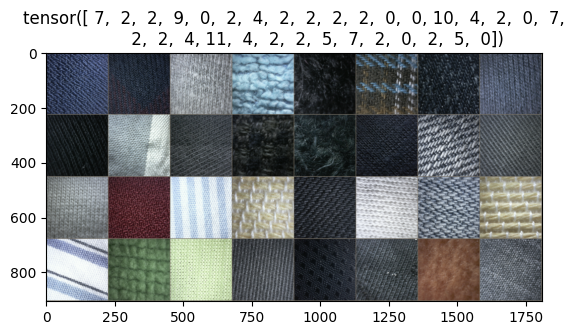

In [9]:
images_data = torchvision.utils.make_grid(images)
imshow(images_data, labels)

#### 2) 모델 불러오기

In [ ]:
from torchvision.models import convnext_tiny
import torch.nn as nn

model = convnext_tiny(pretrained=True)
model

c:\IoLaundry\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\IoLaundry\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [11]:
selected_classes

[6, 7, 15, 8, 23, 3, 14, 17, 10, 22, 5, 19]

In [12]:
# Classifier 수정
selected_classes_len = len(selected_classes)

model.classifier[2] = nn.Linear(model.classifier[2].in_features, selected_classes_len, bias=True)

In [13]:
model.classifier

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=12, bias=True)
)

#### 3) 모델 학습

In [14]:
# 모델 가중치 저장 함수
import os
import torch

def save_model(model, model_name, epoch, save_dir="model/"):
    os.makedirs(save_dir, exist_ok=True)
    save_path_weight = os.path.join(save_dir, f"{model_name}_weight_epoch{epoch}.pth")
    save_path_full = os.path.join(save_dir, f"{model_name}_full_epoch{epoch}.pth")
    torch.save(model.state_dict(), save_path_weight)
    torch.save(model, save_path_full)
    print(f"model saved at epoch {epoch} to: {save_path_weight}")

In [ ]:
from tensorboardX import SummaryWriter
import torch.optim as optim
import tqdm
import os

writer = SummaryWriter()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
epochs = 30
step = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for epoch in range(epochs) :
    for data, labels in tqdm.tqdm(re_train_dataloader):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        
        writer.add_scalar("Loss/train", loss.item(), step)
        step += 1
    
    print(f"{epoch+1} loss ::: {loss.item()}")

    if (epoch + 1) in [10, 20, 30]:
        save_model(model, "convNeXt", epoch+1)

100%|██████████| 174/174 [02:37<00:00,  1.11it/s]


1 loss ::: 1.1233022212982178


100%|██████████| 174/174 [02:34<00:00,  1.13it/s]


2 loss ::: 0.4388698935508728


100%|██████████| 174/174 [02:44<00:00,  1.06it/s]


3 loss ::: 0.9825069308280945


100%|██████████| 174/174 [02:49<00:00,  1.02it/s]


4 loss ::: 0.7883759140968323


100%|██████████| 174/174 [02:48<00:00,  1.03it/s]


5 loss ::: 0.6415521502494812


100%|██████████| 174/174 [02:47<00:00,  1.04it/s]


6 loss ::: 1.2015055418014526


100%|██████████| 174/174 [02:45<00:00,  1.05it/s]


7 loss ::: 0.9805126190185547


100%|██████████| 174/174 [02:46<00:00,  1.05it/s]


8 loss ::: 0.5672186613082886


100%|██████████| 174/174 [02:49<00:00,  1.03it/s]


9 loss ::: 0.6737076044082642


100%|██████████| 174/174 [02:17<00:00,  1.26it/s]


10 loss ::: 0.5804714560508728
model saved at epoch 10 to: model/convNeXt_weight_epoch10.pth


100%|██████████| 174/174 [02:11<00:00,  1.33it/s]


11 loss ::: 0.49169987440109253


100%|██████████| 174/174 [02:14<00:00,  1.29it/s]


12 loss ::: 1.1369447708129883


100%|██████████| 174/174 [02:15<00:00,  1.28it/s]


13 loss ::: 0.31002503633499146


100%|██████████| 174/174 [02:13<00:00,  1.31it/s]


14 loss ::: 0.741281270980835


100%|██████████| 174/174 [02:13<00:00,  1.31it/s]


15 loss ::: 0.770877480506897


100%|██████████| 174/174 [02:13<00:00,  1.30it/s]


16 loss ::: 0.6507774591445923


100%|██████████| 174/174 [02:12<00:00,  1.31it/s]


17 loss ::: 0.5361015796661377


100%|██████████| 174/174 [02:09<00:00,  1.34it/s]


18 loss ::: 0.913399875164032


100%|██████████| 174/174 [02:11<00:00,  1.33it/s]


19 loss ::: 0.3981475532054901


100%|██████████| 174/174 [02:10<00:00,  1.34it/s]


20 loss ::: 0.21710102260112762
model saved at epoch 20 to: model/convNeXt_weight_epoch20.pth


100%|██████████| 174/174 [02:12<00:00,  1.31it/s]


21 loss ::: 0.37772396206855774


100%|██████████| 174/174 [02:10<00:00,  1.33it/s]


22 loss ::: 0.4758721888065338


100%|██████████| 174/174 [02:21<00:00,  1.23it/s]


23 loss ::: 0.46434250473976135


100%|██████████| 174/174 [02:13<00:00,  1.30it/s]


24 loss ::: 0.536932647228241


100%|██████████| 174/174 [02:13<00:00,  1.31it/s]


25 loss ::: 0.4365023672580719


100%|██████████| 174/174 [02:26<00:00,  1.19it/s]


26 loss ::: 0.5930407047271729


100%|██████████| 174/174 [02:46<00:00,  1.04it/s]


27 loss ::: 0.46964460611343384


100%|██████████| 174/174 [02:47<00:00,  1.04it/s]


28 loss ::: 0.5031943917274475


100%|██████████| 174/174 [02:41<00:00,  1.08it/s]


29 loss ::: 0.5819680690765381


100%|██████████| 174/174 [02:43<00:00,  1.07it/s]


30 loss ::: 0.5423113703727722
model saved at epoch 30 to: model/convNeXt_weight_epoch30.pth


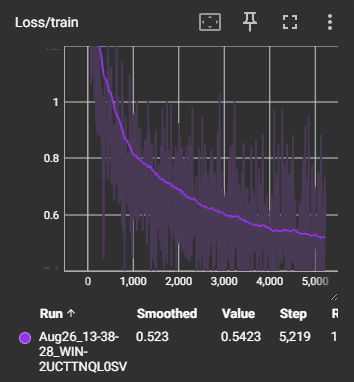

#### 4) 모델 평가

In [17]:
import torch
from sklearn.metrics import f1_score

# 평가
model.eval()

all_preds = []
all_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad() :
    total_corr = 0
    for images, labels in re_test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # 3. 모델 추론
        outputs = model(images)                 # (batch_size, num_classes)
        preds = torch.argmax(outputs, dim=1)    # 가장 확률 높은 클래스로 예측

        # 4. 결과 수집 (CPU로 옮기기)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# f1 score 계산
f1_macro = f1_score(all_labels, all_preds, average="macro")         # 적은 클래스도 똑같이 반영
f1_weighted = f1_score(all_labels, all_preds, average="weighted")   # 샘플 수 비율 반영 (-> 클래스 불균형 심할때)
print(f"f1 score (macro) : {f1_macro:.4f}")
print(f"f1 score (weighted) : {f1_weighted:.4f}")

f1 score (macro) : 0.8233
f1 score (weighted) : 0.7822


### 2차 (클래스 병합)

- 삭제 class = [Artificial_fur, Artificial_leather, Felt, Lut, Utilities, Suede]
- 남은 class = [Acrylic, Blended, Chenille, Corduroy, Cotton, Crepe, Denim,  
Fleece, Leather, Linen, Nylon, Polyester, Satin, Silk,  
Terrycloth, Velvet, Viscose, Wool] -> 8개의 클래스로 병합

#### 1) 데이터 불러오기 & 전처리

In [26]:
from common.transforms import get_transforms
from common.model_loader import load_convNeXt
from common.metrics import evaluate_model

In [27]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [28]:
# 전처리
train_transform = get_transforms("train")
test_transform = get_transforms("test")

train_raw = ImageFolder("./dataset/train", transform=train_transform)
test_raw = ImageFolder("./dataset/test", transform=test_transform)

In [29]:
# 병합된 클래스 매핑 -> 8개의 클래스로 병합
class_merge_map = {
    'Cotton': 0,
    'Linen': 0,
    'Viscose': 0,
    'Blended': 1,
    'Polyester': 1,
    'Nylon': 1,
    'Satin': 2,
    'Silk': 2,
    'Wool': 3,
    'Acrylic': 3,
    'Fleece': 4,
    'Terrycloth': 4,
    'Chenille': 4,
    'Denim': 5,
    'Corduroy': 5,
    'Velvet': 6,
    'Crepe': 6,
    'Leather': 7
}

In [ ]:
# 클래스 병합
from torch.utils.data import Dataset
from PIL import Image

class FilteredImageFolder(Dataset):
    def __init__(self, imagefolder_dataset, class_merge_map):
        self.transform = imagefolder_dataset.transform
        self.loader = imagefolder_dataset.loader
        
        # 원래 클래스 인덱스 → 클래스 이름 리스트
        idx_to_class = imagefolder_dataset.classes  # ex) ['Acrylic', 'Blended', ...]
        
        # 병합된 샘플을 저장할 리스트 초기화
        self.samples = []

        for path, label in imagefolder_dataset.samples:
            class_name = idx_to_class[label]

            # class_merge_map에 해당 클래스가 있으면 병합된 라벨 가져오기
            if class_name in class_merge_map:
                merged_label = class_merge_map[class_name]
                 # 병합된 라벨로 샘플 저장 (이미지 경로, 병합된 라벨)
                self.samples.append((path, merged_label))
            # else: 없으면 그냥 제외

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = self.loader(path)
        if self.transform:
            image = self.transform(image)
        return image, label

In [32]:
# 병합 적용
train_dataset = FilteredImageFolder(train_raw, class_merge_map)
test_dataset = FilteredImageFolder(test_raw, class_merge_map)

In [33]:
# Dataloader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### 2) 모델 불러오기

In [34]:
from torchvision.models import convnext_tiny
import torch.nn as nn

model = convnext_tiny(pretrained=True)
model

c:\IoLaundry\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\IoLaundry\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [35]:
# Classifier 수정
classes_len = len(set(class_merge_map.values()))
model.classifier[2] = nn.Linear(model.classifier[2].in_features, classes_len, bias=True)

In [36]:
model.classifier

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=8, bias=True)
)

#### 3) 모델 학습

In [37]:
# 모델 가중치 저장 함수
import os
import torch

def save_model(model, model_name, epoch, save_dir="model/"):
    os.makedirs(save_dir, exist_ok=True)
    save_path_weight = os.path.join(save_dir, f"{model_name}_weight_epoch{epoch}.pth")
    save_path_full = os.path.join(save_dir, f"{model_name}_full_epoch{epoch}.pth")
    torch.save(model.state_dict(), save_path_weight)
    torch.save(model, save_path_full)
    print(f"model saved at epoch {epoch} to: {save_path_weight}")

In [38]:
from tensorboardX import SummaryWriter
import torch.optim as optim
import tqdm
import os

writer = SummaryWriter()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
epochs = 30
step = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for epoch in range(epochs) :
    for data, labels in tqdm.tqdm(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        
        writer.add_scalar("Loss/train", loss.item(), step)
        step += 1
    
    print(f"{epoch+1} loss ::: {loss.item()}")

    if (epoch + 1) in [10, 20, 30]:
        save_model(model, "convNeXtTiny_mergeClass", epoch+1)

100%|██████████| 183/183 [02:46<00:00,  1.10it/s]


1 loss ::: 0.9667155146598816


100%|██████████| 183/183 [02:44<00:00,  1.11it/s]


2 loss ::: 1.1580042839050293


100%|██████████| 183/183 [02:46<00:00,  1.10it/s]


3 loss ::: 0.7111702561378479


100%|██████████| 183/183 [02:40<00:00,  1.14it/s]


4 loss ::: 0.6688518524169922


100%|██████████| 183/183 [02:57<00:00,  1.03it/s]


5 loss ::: 0.3454909026622772


100%|██████████| 183/183 [02:50<00:00,  1.07it/s]


6 loss ::: 0.8094580173492432


100%|██████████| 183/183 [02:54<00:00,  1.05it/s]


7 loss ::: 0.5945667624473572


100%|██████████| 183/183 [02:49<00:00,  1.08it/s]


8 loss ::: 0.5620049238204956


100%|██████████| 183/183 [02:49<00:00,  1.08it/s]


9 loss ::: 0.3093567490577698


100%|██████████| 183/183 [02:54<00:00,  1.05it/s]


10 loss ::: 0.8282343149185181
model saved at epoch 10 to: model/convNeXtTiny_mergeClass_weight_epoch10.pth


100%|██████████| 183/183 [02:52<00:00,  1.06it/s]


11 loss ::: 0.4722943603992462


100%|██████████| 183/183 [02:52<00:00,  1.06it/s]


12 loss ::: 0.5325689911842346


100%|██████████| 183/183 [02:54<00:00,  1.05it/s]


13 loss ::: 0.48847389221191406


100%|██████████| 183/183 [02:55<00:00,  1.04it/s]


14 loss ::: 0.5912501811981201


100%|██████████| 183/183 [02:55<00:00,  1.04it/s]


15 loss ::: 0.6359780430793762


100%|██████████| 183/183 [02:52<00:00,  1.06it/s]


16 loss ::: 0.22387723624706268


100%|██████████| 183/183 [03:02<00:00,  1.00it/s]


17 loss ::: 0.29550719261169434


100%|██████████| 183/183 [03:13<00:00,  1.06s/it]


18 loss ::: 0.5142961144447327


100%|██████████| 183/183 [02:53<00:00,  1.05it/s]


19 loss ::: 0.2669333517551422


100%|██████████| 183/183 [02:16<00:00,  1.34it/s]


20 loss ::: 0.5015280246734619
model saved at epoch 20 to: model/convNeXtTiny_mergeClass_weight_epoch20.pth


100%|██████████| 183/183 [02:15<00:00,  1.35it/s]


21 loss ::: 0.4754111170768738


100%|██████████| 183/183 [02:14<00:00,  1.36it/s]


22 loss ::: 0.39691585302352905


100%|██████████| 183/183 [02:14<00:00,  1.36it/s]


23 loss ::: 0.40979668498039246


100%|██████████| 183/183 [02:14<00:00,  1.36it/s]


24 loss ::: 0.40686774253845215


100%|██████████| 183/183 [02:14<00:00,  1.36it/s]


25 loss ::: 0.5120436549186707


100%|██████████| 183/183 [02:13<00:00,  1.37it/s]


26 loss ::: 0.5409716367721558


100%|██████████| 183/183 [02:14<00:00,  1.36it/s]


27 loss ::: 0.40348783135414124


100%|██████████| 183/183 [02:17<00:00,  1.33it/s]


28 loss ::: 0.2090836763381958


100%|██████████| 183/183 [02:17<00:00,  1.33it/s]


29 loss ::: 0.5022802352905273


100%|██████████| 183/183 [02:25<00:00,  1.26it/s]


30 loss ::: 0.4319174289703369
model saved at epoch 30 to: model/convNeXtTiny_mergeClass_weight_epoch30.pth


#### 4) 모델 평가

In [40]:
merged_label_names = [
    "Cotton류",       # 0
    "Blended류",      # 1
    "Satin/Silk류",   # 2
    "Wool/Acrylic류", # 3
    "Fleece류",       # 4
    "Denim/Corduroy류",# 5
    "Velvet/Crepe류", # 6
    "Leather류"       # 7
]

In [ ]:
import torch
from sklearn.metrics import classification_report

# 평가
model.eval()

all_preds = []
all_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad() :
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 3. 모델 추론
        outputs = model(images)                 # (batch_size, num_classes)
        preds = torch.argmax(outputs, dim=1)    # 가장 확률 높은 클래스로 예측

        # 4. 결과 수집 (CPU로 옮기기)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 병합된 라벨 기준으로 리포트 생성
report = classification_report(all_labels, all_preds, target_names=merged_label_names)
print(report)


                 precision    recall  f1-score   support

        Cotton류       0.81      0.77      0.79       517
       Blended류       0.75      0.81      0.78       556
    Satin/Silk류       0.83      0.83      0.83        60
  Wool/Acrylic류       0.80      0.67      0.73        82
        Fleece류       0.98      0.87      0.92        62
Denim/Corduroy류       0.95      0.97      0.96       150
  Velvet/Crepe류       0.67      0.60      0.63        30
       Leather류       0.86      0.92      0.89        13

       accuracy                           0.80      1470
      macro avg       0.83      0.81      0.82      1470
   weighted avg       0.81      0.80      0.80      1470



### 3차 (이미지 randomCrop)

In [42]:
from common.transforms import get_transforms
from common.model_loader import load_convNeXt
from common.metrics import evaluate_model

#### 1) 데이터 불러오기 & 전처리

In [57]:
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

In [58]:
# 전처리 (Crop 사용)
transforms_train = transforms.Compose([
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [59]:
train_raw = ImageFolder("./dataset/train", transform=transforms_train)
test_raw = ImageFolder("./dataset/test", transform=transforms_test)

In [60]:
train_dataloader = DataLoader(train_raw, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_raw, batch_size=32, shuffle=False)

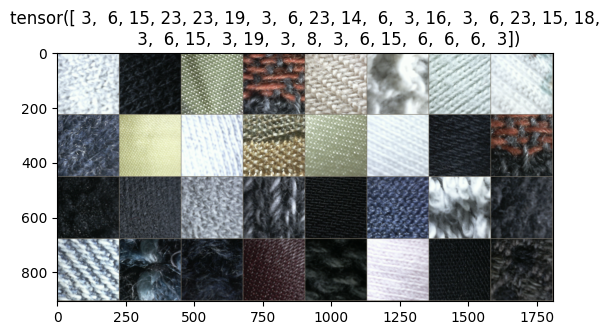

In [61]:
images, labels = next(iter(train_dataloader))

import matplotlib.pyplot as plt
import numpy as np

# 이미지를 화면에 출력하는 함수
def imshow(img, title) :
    img = img.numpy().transpose([1, 2, 0])

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    img = img * std + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.title(title)
    plt.show()

images_data = torchvision.utils.make_grid(images)
imshow(images_data, labels)

#### 2) 모델 불러오기

In [62]:
from torchvision.models import convnext_tiny
import torch.nn as nn

model = convnext_tiny(pretrained=True)
model

c:\IoLaundry\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\IoLaundry\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [63]:
# Classifier 수정
model.classifier[2] = nn.Linear(model.classifier[2].in_features, 24, bias=True)

In [64]:
model.classifier

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=24, bias=True)
)

#### 3) 모델 학습

In [65]:
# 모델 가중치 저장 함수
import os
import torch

def save_model(model, model_name, epoch, save_dir="model/"):
    os.makedirs(save_dir, exist_ok=True)
    save_path_weight = os.path.join(save_dir, f"{model_name}_weight_epoch{epoch}.pth")
    save_path_full = os.path.join(save_dir, f"{model_name}_full_epoch{epoch}.pth")
    torch.save(model.state_dict(), save_path_weight)
    torch.save(model, save_path_full)
    print(f"model saved at epoch {epoch} to: {save_path_weight}")

In [66]:
import torch
from sklearn.metrics import classification_report

def eval_model(model, epoch):
    # 평가
    model.eval()

    all_preds = []
    all_labels = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad() :
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # 3. 모델 추론
            outputs = model(images)                 # (batch_size, num_classes)
            preds = torch.argmax(outputs, dim=1)    # 가장 확률 높은 클래스로 예측

            # 4. 결과 수집 (CPU로 옮기기)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 병합된 라벨 기준으로 리포트 생성
    report = classification_report(all_labels, all_preds)
    print("="*50)
    print(f"epoch : {epoch}번째 모델 평가")
    print(report)


In [ ]:
from tensorboardX import SummaryWriter
import torch.optim as optim
import tqdm

writer = SummaryWriter()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
epochs = 30
step = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for epoch in range(epochs) :
    for data, labels in tqdm.tqdm(train_dataloader) :
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        
        writer.add_scalar("Loss/train", loss.item(), step)
        step += 1
    
    print(f"{epoch+1} loss ::: {loss.item()}")

    if (epoch + 1) in [10, 20, 30]:
        save_model(model, "convNeXtTiny_crop", epoch+1)
        eval_model(model, epoch+1)

#### 4) 모델 평가

In [56]:
import torch
from sklearn.metrics import classification_report
from common.metrics import evaluate_model

# 평가
model.eval()

all_preds = []
all_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad() :
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 3. 모델 추론
        outputs = model(images)                 # (batch_size, num_classes)
        preds = torch.argmax(outputs, dim=1)    # 가장 확률 높은 클래스로 예측

        # 4. 결과 수집 (CPU로 옮기기)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 병합된 라벨 기준으로 리포트 생성
# report = classification_report(all_labels, all_preds, target_names=merged_label_names)
# print(report)


# 평가지표 계산
metrics = evaluate_model(all_preds, all_labels)
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")


Accuracy: 0.0184
F1 Score: 0.0212
Precision: 0.0179
Recall: 0.1045


c:\IoLaundry\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\IoLaundry\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
